# Demonstrate GridsearchCV

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

To demonstrate why nested cv is helpful, a simple model will be created.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Notebook
As per the *Demonstrate Internals of Cross Validation using a Pipeline* notebook:

In [2]:
# read king county housing data
all_data = pd.read_csv('./data/kc_house_data.csv')

# let's say the house was built, when it was last renovated
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']

# remove the fields discussed above
all_data = all_data.drop(['id', 'date', 'zipcode', 'yr_renovated'], axis=1)

X_all = all_data.drop('price', axis=1)
y_all = all_data['price']

all_data.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062


In [3]:
print(X_all.shape)
print(y_all.shape)

(21613, 16)
(21613,)


### EDA for Model Building
A simple KNN model will be used.  But because KNN suffers from the "curse of dimensionality", the dimensionality of the feature set will be reduced with PCA.  PCA expects variables on the same scale, so the features will be standardized.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scale = StandardScaler()
pca = PCA(n_components=16)
pca_info = pca.fit(scale.fit_transform(X_all))

In [5]:
np.cumsum(pca_info.explained_variance_ratio_)

array([0.32133869, 0.44600789, 0.55886284, 0.63892456, 0.70449055,
       0.75874935, 0.80765459, 0.84873892, 0.88736661, 0.91853478,
       0.93975537, 0.9575939 , 0.97359186, 0.98771426, 1.        ,
       1.        ])

Text(0.5,1,'Cumulative Variance Explained')

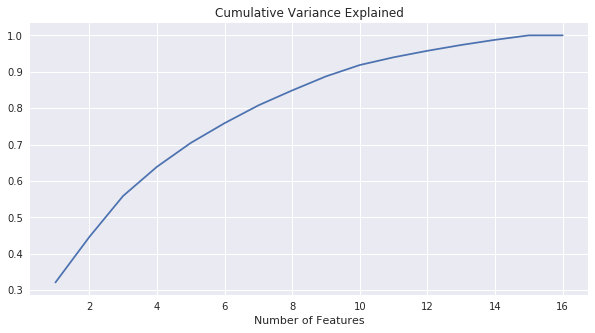

In [6]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,17), np.cumsum(pca_info.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.title('Cumulative Variance Explained')

At 9 features, we reach about 90% of the variance explained.

In [7]:
# Examine the magnitude of each coordinate in the transformed feature space
features_transformed = pca.fit_transform(scale.fit_transform(X_all))

# mean of squared coordinate values
coordinate_mag = (features_transformed * features_transformed).mean(axis=0)
np.round(coordinate_mag, 3)

array([5.141, 1.995, 1.806, 1.281, 1.049, 0.868, 0.782, 0.657, 0.618,
       0.499, 0.34 , 0.285, 0.256, 0.226, 0.197, 0.   ])

The magnitude of the transformed coordinates decreases with increasing coordinate index.  This is because the transformed coordinates are ordered by the amount of variance they explain.  This is to the advantage of the KNN model.

Normally KNN suffers from the "curse of dimensionality".  The size of the feature space grows exponentially with the number of features.  Points in a large feature space are not "close" and therefore KNN does not work well.  However with PCA transformed coordinates, often only the first coordinates are contributing significantly to the location of the point in feature space. The effective size of the feature space is greatly reduced, allowing KNN to be more effective.

### Hyperparameter Tuning with GridsearchCV
The hyperparameter search space will be:
* number of PCA transformed dimensions
* K in KNN
* uniform vs distance weighting of K nearest neighbors

In [8]:
# Depending on software versions, spurious deprecation warnings messages may occur
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
np.cumsum(pca_info.explained_variance_ratio_)[9]

0.9185347815359741

About 92% of the variance is explained in the first 10 PCA components.  As such, it is unlikely that using more PCA components (with small coordinate values) would have a meaningful impact on the KNN model.

In [10]:
# Number of PCA components to use
n_components = list(np.arange(10)+1)
n_components

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
# K in KNN
n_neighbors = [1, 5, 10, 20]
n_neighbors

[1, 5, 10, 20]

KNN has an option for how it averages the points it finds in nearby space.  'Uniform' means to average the target value (e.g. housing price) of the K closest points as the prediction.  'Distance" means to perform a weighted average of the K closest points where points further away are weighted less.

In [12]:
param_grid = {
        'pca__n_components': n_components,
        'knn__n_neighbors': n_neighbors,
        'knn__weights':['uniform', 'distance']
}

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

scale = StandardScaler()
pca = PCA()
knn = KNeighborsRegressor()

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 5
random_seed=108
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

grid = GridSearchCV(pipe, cv=crossvalidation, n_jobs=1, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', verbose=1)

In [53]:
# This takes about 3 minutes on my 4-core 3.7 GHz hyperthreaded Xeon E5-1630 box 
grid.fit(X_all,y_all)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=108, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'knn__n_neighbors': [1, 5, 10, 20], 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

The results for the cross validated grid search are stored in grid.cv_results_.  This is a dictionary with keys such as 'mean_test_score', 'split0_test_score', etc.  For each combination of grid values, there is a score for each cross validated fold.

### Helper Functions to get Data from grid

In [54]:
def get_test_scores(grid):
    keys = []
    for key in grid.cv_results_.keys():
        if 'split' in key and 'test' in key:
            keys.append(key)
    return keys

In [55]:
# keys for each of K test folds
get_test_scores(grid)

['split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score']

In [56]:
# paramter grid passed in
grid.param_grid

{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'knn__n_neighbors': [1, 5, 10, 20],
 'knn__weights': ['uniform', 'distance']}

In [57]:
# GridSearchCV places the results in alphabetical order of paramter name
grid.cv_results_['params'][:12]

[{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 1},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 2},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 3},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 4},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 5},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 6},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 7},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 8},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 9},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 10},
 {'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 1},
 {'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 2}]

In [58]:
# Get the dimensions of the parameter grid
def get_dim(grid):
    dims = []
    for key in sorted(grid.param_grid.keys()):
        dims.append(len(grid.param_grid[key]))
    return tuple(dims)

In [59]:
# dimensions of parameter grid
get_dim(grid)

(4, 2, 10)

These dimensions matche what is seen above for grid.cv_results_\['params'\]

In [60]:
# get the test data out as an array
def get_test_data(grid):
    dim = get_dim(grid)
    new_dim = (grid.cv.get_n_splits(), *dim)

    result = np.zeros(new_dim)
    for i, key in enumerate(get_test_scores(grid)):
        data = np.array(grid.cv_results_[key])
        data = data.reshape(dim)
        result[i] = data

    return result

In [61]:
# K=5, so there are 5 (4,2,9) arrays
get_test_data(grid).shape

(5, 4, 2, 10)

In [62]:
# verify the helper functions work properly

# computing the mean along axis zero provides the mean of each 
# cross validated fold at every point in the paramater grid
test_data = get_test_data(grid)
mean_scores = test_data.mean(axis=0)
print(mean_scores.shape)

mean_scores2 = grid.cv_results_['mean_test_score']
mean_scores2 = mean_scores2.reshape(get_dim(grid))
print(np.allclose(mean_scores, mean_scores2, rtol=2e-5))

(4, 2, 10)
True


So ** grid.cv_results_\['mean_test_score'\] ** is the same as the mean of the test scores retrieved by the helper functions

In [63]:
# verify helper functions also work for the std scores

# same as above
test_data = get_test_data(grid)
std_scores = test_data.std(axis=0)
print(std_scores.shape)

std_scores2 = grid.cv_results_['std_test_score']
std_scores2 = std_scores2.reshape(get_dim(grid))
print(np.allclose(std_scores, std_scores2, rtol=4e-5))

(4, 2, 10)
True


In [64]:
# compute RMSE
# each score on each fold is the negative mean squared error
# the RMSE for a single value is the sqrt of the abs of that number
# taking the mean over the K folds, creates a cross validated mean score for RMSE
test_data = get_test_data(grid)
rmse_scores = np.sqrt(np.abs(test_data)).mean(axis=0)

# compute standard deviation of RMSE
std_scores = np.sqrt(np.abs(test_data)).std(axis=0)

It is not possible to get the RMSE values from the sqrt of the mean_test_score values
```pre
sqrt of abs of mean_test_score  = sqrt of abs of mean of neg-squared-error  
rmse_scores                     = mean of sqrt of abs of neg-squared-error
sqrt of abs of mean_test_score != rmse_scores
```

Same for standard deviations.

```pre
sqrt of abs of std_test_score  = sqrt of abs of std of neg-squared-error  
std_scores                     = std of sqrt of abs of neg-squared-error
sqrt of abs of std_test_score != std_scores 
```

In [65]:
# split out the uniformly weighted from the distance weighted mean of the K target values
rmse_uniform = rmse_scores[:,0,:]
rmse_dist    = rmse_scores[:,1,:]
std_uniform   = std_scores[:,0,:]
std_dist      = std_scores[:,1,:]
print(rmse_uniform.shape)

(4, 10)


Text(0.5,1,'RMSE Uniform Weighting')

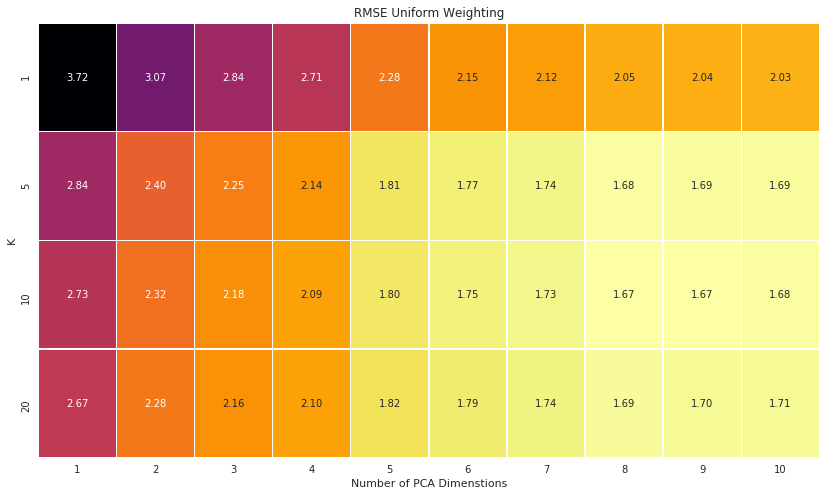

In [66]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_uniform/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Uniform Weighting')

Text(0.5,1,'RMSE Distance Weighting')

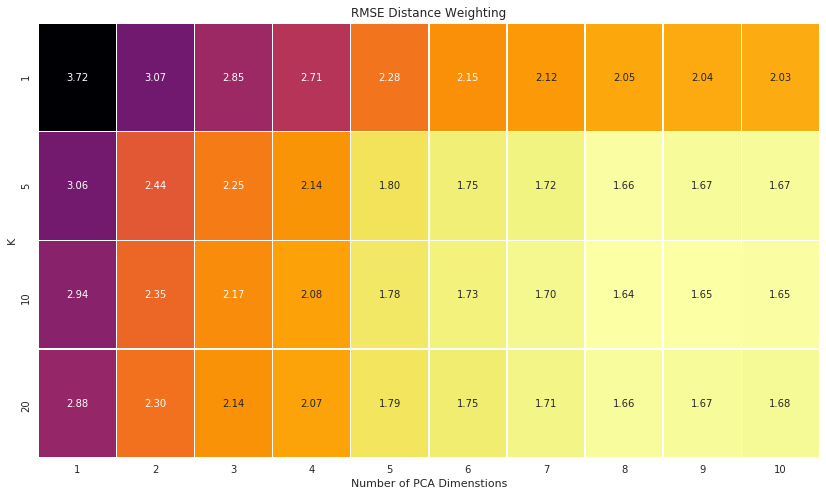

In [67]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_dist/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Distance Weighting')

Text(0.5,1,'Standard Devation of RMSE Uniform Weighting')

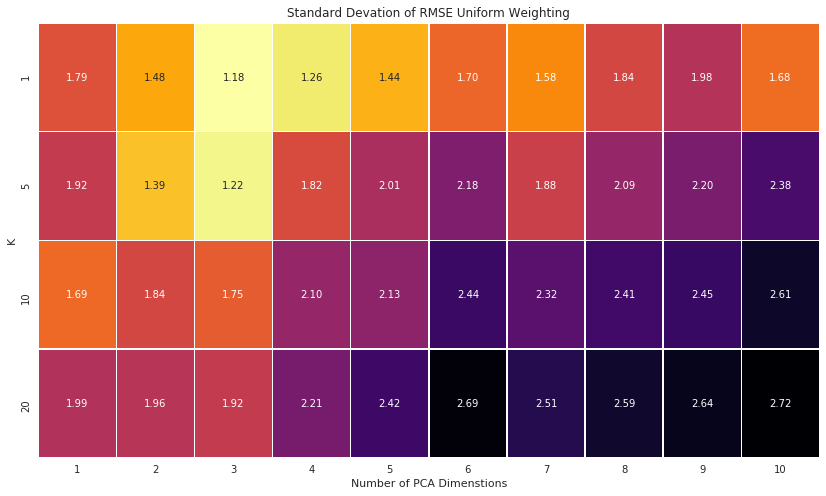

In [68]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_uniform/1e4, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Uniform Weighting')

Text(0.5,1,'Standard Devation of RMSE Distance Weighting')

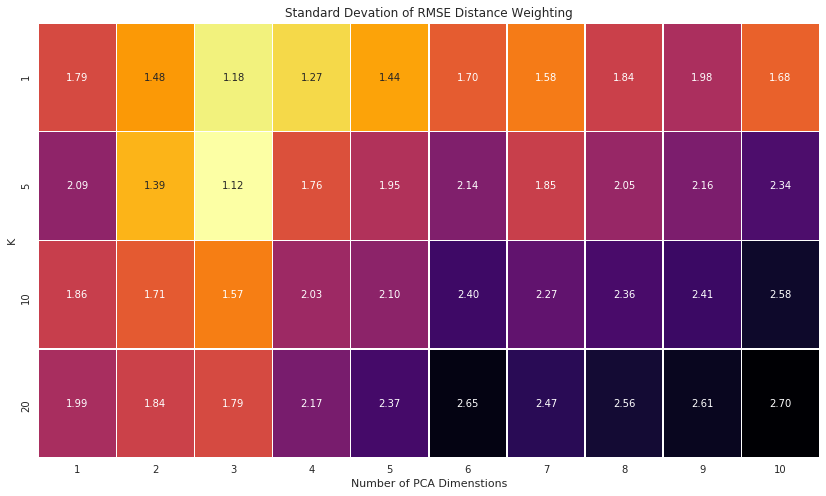

In [69]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_dist/1e4, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Distance Weighting')

Try cross_val_score using the same parameters

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(weights='distance', n_neighbors=10)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 5
random_seed=108
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

scores = cross_val_score(pipe, X_all, y_all, cv=crossvalidation, 
                         scoring='neg_mean_squared_error', n_jobs=1)

# RMSE
rmse = np.sqrt(np.abs(scores)).mean()
rmse

164481.62704016088

In [95]:
# verify the rmse scores computed above match
print(grid.param_grid['knn__n_neighbors'][2])
print(grid.param_grid['knn__weights'][1])
print(grid.param_grid['pca__n_components'][7])

# RMSE for K = 10, weight = distance, PCA components = 8
rmse_scores[2,1,7]

10
distance
8


164481.62704016088

### Cross Validation without Pipeline or cross_value_score
The following produces exactly the same result as above.  It takes many more lines of code, but it is instructive for understanding how cross_value_score is using the pipeline behind the scences.

In [ ]:
# From Above
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

# Use crossvalidation iterator explicitly
my_scores = []
for train_idx, test_idx in crossvalidation.split(X_all):
    
    # train subset
    X_train = X_all.iloc[train_idx, :]
    y_train = y_all.values[train_idx]
    
    X_train_std = scale.fit_transform(X_train)
    X_train_std_pca = pca.fit_transform(X_train_std)
    
    # test subset
    X_test = X_all.iloc[test_idx, :]
    y_test = y_all.values[test_idx]
    
    X_test_std = scale.transform(X_test)
    X_test_std_pca = pca.transform(X_test_std)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict using fitted model on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_squared_error(y_test, predictions))

# print results
rmse2 = np.sqrt(np.abs(my_scores)).mean()
print(rmse == rmse2)

The above code produces exactly the same result as the more concise code that used a pipeline and cross_val_score().

### Effect of Data Size and K Fold
The full dataset consists of 21613 records.  We can simulate having less observations by taking a random sample of these records of smaller size.  In the following, the size of the sample varies on a log scale from 20% to 100% of the total data.

A given random sample of data may be unrepresentative of the data as a whole.  To account for this, 10 bootstrap samples of the specified size are chosen (sampling with replacement) and the statics about those 10 samples are averaged.  Normally bootstrapping involves a lot more than 10 bootstrapped samples, but as the statistic of interest is the cross validated scores, this is computationally expensive.

As the amount of data increases, the expectation is that the RMSE decreases.  The model is more accurate with more data to train on.

As the amount of data increases, the expectation is that the standard deviation of the RMSE cross validated scores decreases.  With more data, the model can better focus on the signal from the noise, and produce a more stable prediction.

Cross Validation provides an estimate of the model's performance.  It does not provide the model to be deployed to production. The model to be deployed to production should use all available data (unless there is so much data that this is unnecessary).

Cross validation provides a pessimistic estimate of the model's performance because it is built on less than the full amount of available data. ("Pessimistic" in this context means that the estimated performance is worse than the actual performance.)  Of course, if there is "data leakage", then cross validation provides a wildly optimistic estimate of performance.  But this is not the fault of cross validation, rather the fault is in the model building process.

Using 3 fold cross validation uses less data for model building (67%) than using 10 fold cross validation (90%).  As the number of folds goes up, the overly pessimistic bias goes down, and the estimate of model performance improves.

Using 3 fold cross validation uses more data for the validation (33%) than using 10 fold cross validation (10%). As the number of folds goes up, the variance of the performance estimates also goes up, having less data to validate the model on.

All of the above is graphically demonstrated below.

In [ ]:
from numpy.random import choice

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

np.random.seed(9)
df = pd.DataFrame()
counter=0

# 10 "bootstraped" subsets of the original data
for i in range(10):
    
    # vary the number of folds
    for k_folds in [3, 5, 10, 20]:
        random_seed=5
        crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                            random_state=random_seed)
    
        # use 10 different fractions of the total data
        # those fractions are on a log scale from 0.2 to 1.0
        for frac in np.logspace(np.log10(0.2), np.log10(1.0), 10):
            
            # this takes a long time, print something to be sure its running
            counter += 1
            print(counter, end=' ')
            
            # get a random sample of the data
            n = int(frac*len(X_all))
            idx = choice(len(X_all), size=n, replace=True)
            X = X_all.iloc[idx]
            y = y_all.values[idx]

            # compute the K cross validated scores
            scores = cross_val_score(pipe, X, y, cv=crossvalidation, 
                                 scoring='neg_mean_squared_error', n_jobs=1)

            # scikit learn returns these as negative mean squared error
            # more common is root-mean-squared-error
            rmse_values = np.sqrt(np.abs(scores))
            std_value = rmse_values.std()

            # use the mean of the cross validated scores
            rmse = rmse_values.mean()

            # accumulate the results
            df = df.append(pd.DataFrame(data=[[k_folds, n, rmse, std_value]], 
                                        columns=['k_fold', 'len', 'rmse', 'std']),
                           ignore_index=True)

In [ ]:
rmse_data = df.groupby(['k_fold', 'len'])['rmse'].mean()
rmse_data.head(11)

In [ ]:
type(rmse_data)

In [ ]:
# applying the mean operator to the 2 field groupby creates
# a Pandas series with a 2 part index
# Data can be extracted via the outer index (K-fold)
rmse_data[3]

In [ ]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))
rmse_data = df.groupby(['k_fold','len'])['rmse'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, rmse_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.title('RMSE vs Records per K-Fold CV')

The general trend that more data lowers the RMSE is clear.

The general trend that more CV Folds results in a lower RMSE estimate is also clear.  This is because the amount of pessimisum in the bias is less, as there is more data available for training with more folds.

Note: this does not mean the model "built by k-fold cross validation" with a higher number of folds is better.  The model to be deployed is not one of the models built during cross validation.  Rather this means that the estimate of the model's performance has less bias when k is larger.

In [ ]:
plt.figure(figsize=(12,6))
std_data = df.groupby(['k_fold','len'])['std'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(std_data.loc[k].index.values, std_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('Standard Dev of RMSE')
plt.title('Standard Dev of RMSE vs Records per K-Fold CV')

The general trend that more data lowers the standard deviation of the RMSE estimate is clear.

The general trend that more CV Folds results in more variance is also clear.  This is because there is less validation data available with the are more folds.

### Which Value of K is "Best"
The Bias-Variance tradeoff means that for a more accurate estimate of the model's performance, the higher the variance of that estimate.  As such, there is no "best" value.

For the above model, it might be argued that K=5 results in a good tradeoff of bias vs variance.